# **WiDS Datathon 2025 - Unraveling the Mysteries of the Female Brain: Sex Patterns in ADHD**
## **Authors:** Sergiu Buhatel and Ramy El Gharbawy

## **Import the necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

# Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score

# For tuning the model
from sklearn.model_selection import GridSearchCV
from IPython.display import display, HTML, Markdown

import joblib  # For saving and loading the model

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from IPython.display import display, Markdown

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

## **Data Overview**

- Reading the dataset
- Understanding the shape of the dataset
- Checking the data types
- Checking for missing values

In [2]:
# Loading the datasets
df_train_categorical = pd.read_excel('./Data/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx').set_index("participant_id")
df_train_functional = pd.read_csv('./Data/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv').set_index("participant_id")
df_train_quantitative = pd.read_excel('./Data/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx').set_index("participant_id")
df_training_solutions = pd.read_excel('./Data/TRAIN/TRAINING_SOLUTIONS.xlsx').set_index("participant_id")

df_test_categorical = pd.read_excel('./Data/TEST/TEST_CATEGORICAL.xlsx').set_index("participant_id")
df_test_functional = pd.read_csv('./Data/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv').set_index("participant_id")
df_test_quantitative = pd.read_excel('./Data/TEST/TEST_QUANTITATIVE_METADATA.xlsx').set_index("participant_id")

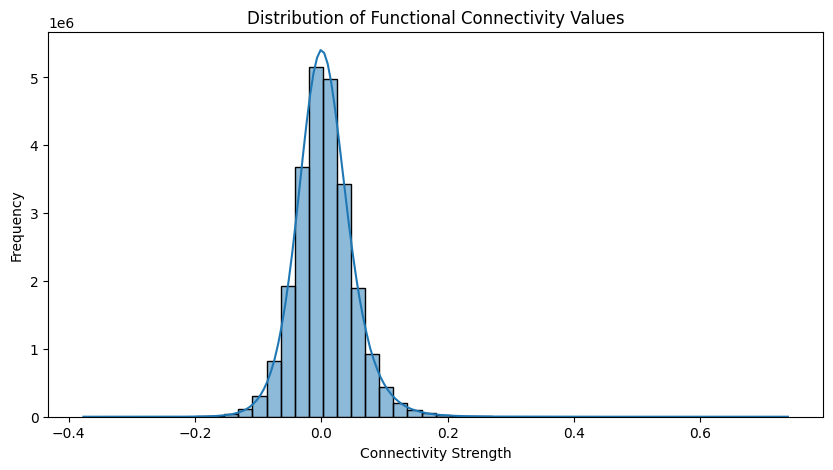

In [3]:
# PLotting a histogram of the functional connectivity values
plt.figure(figsize=(10, 5))
sns.histplot(df_train_functional.values.flatten(), bins=50, kde=True)
plt.xlabel("Connectivity Strength")
plt.ylabel("Frequency")
plt.title("Distribution of Functional Connectivity Values")
plt.show()

Is the matrix symmetric? True


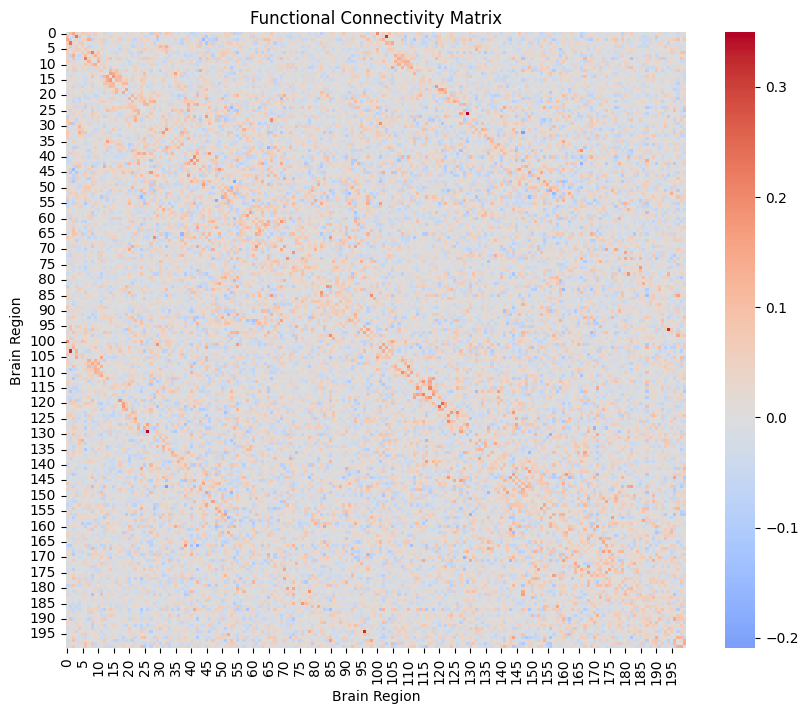

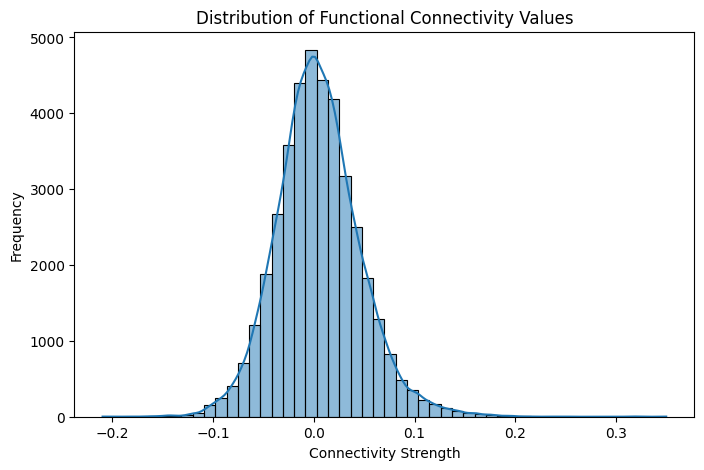

In [4]:
values = df_train_functional.iloc[0, :].values

if values.shape[0] == 19900:  # Likely an upper-triangle representation
    n = 200  # Assuming 200 regions
    matrix = np.zeros((n, n))  # Create empty symmetric matrix

    # Get upper triangle indices
    triu_indices = np.triu_indices(n, k=1)

    # Fill the upper triangle
    matrix[triu_indices] = values

    # Mirror to make it symmetric
    matrix = matrix + matrix.T

#  Check symmetry
print("Is the matrix symmetric?", np.allclose(matrix, matrix.T, atol=1e-5))

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap="coolwarm", center=0)
plt.title("Functional Connectivity Matrix")
plt.xlabel("Brain Region")
plt.ylabel("Brain Region")
plt.show()

# Plot histogram of values
plt.figure(figsize=(8, 5))
sns.histplot(matrix.flatten(), bins=50, kde=True)
plt.title("Distribution of Functional Connectivity Values")
plt.xlabel("Connectivity Strength")
plt.ylabel("Frequency")
plt.show()

In [5]:
# Copying data to another variable to avoid any changes to original data
data_train_categorical=df_train_categorical.copy()
data_train_functional=df_train_functional.copy()
data_train_quantitative=df_train_quantitative.copy()
data_training_solutions=df_training_solutions.copy()

data_test_categorical=df_test_categorical.copy()
data_test_functional=df_test_functional.copy()
data_test_quantitative=df_test_quantitative.copy()

In [6]:
def display_head_with_scroll(data):
    # Convert the DataFrame to HTML and wrap it with a div that enables horizontal scrolling
    html = data.head().to_html()
    html_with_scroll = f'<div style="overflow-x: auto; white-space: nowrap;">{html}</div>'
    
    # Display the HTML with the scroll
    display(HTML(html_with_scroll))

# Check for null values
def columns_containing_null(df):
    # Get the count of null values per column
    null_count = df.isnull().sum()
    
    # Filter to show only columns with null values
    columns_with_nulls = null_count[null_count > 0]
    
    print("\nColumns containing null and how many values are null:\n" + str(columns_with_nulls) + "\n")

def summary_statistics(data):
    # Creating numerical columns
    num_cols = data.select_dtypes('number').columns
    
    # Checking the descriptive statistics of the numerical columns
    html = data[num_cols].describe().T.to_html()

    html_with_scroll = f'<div style="overflow-x: auto; white-space: nowrap;">{html}</div>'
    
    # Display the HTML with the scroll
    display(HTML(html_with_scroll))
    
def display_data(data, title = None):
    if title is not None:
        # Display the title as an h1 header
        display(HTML(f'<h3>{title}</h1>'))
        
    display_head_with_scroll(data)

    # Get shape of the dataset in terms of number of rows and number of colums
    print("Shape:" + str(data.shape) + "\n")
    
    # Check the data types as part of the info of the data
    data_train_categorical.info() 

    # Check for null values
    columns_containing_null(data)

    # Summary statistics
    summary_statistics(data)

# Function to get participant IDs with rows that have null values
def get_participant_ids_with_nulls(df):
    # Identify rows with any null value
    rows_with_nulls = df[df.isnull().any(axis=1)]
    
    # Get the participant_id (index) of those rows
    participant_ids_with_nulls = rows_with_nulls.index.tolist()
    
    return participant_ids_with_nulls
    
def display_shape_and_null_data(data, title = None):
    if title is not None:
        # Display the title as an h1 header
        display(HTML(f'<h3>{title}</h1>'))

    # Get shape of the dataset in terms of number of rows and number of colums
    print("Shape:" + str(data.shape) + "\n")

    # Check for null values
    participant_ids_with_nulls = get_participant_ids_with_nulls(data)
    print("Number of columns with null value:" + str(len(participant_ids_with_nulls)))

In [7]:
display_data(data_train_categorical, "TRAIN_CATEGORICAL_METADATA.xlsx")

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
participant_id,,,,,,,,,
UmrK0vMLopoR,2016,1,0.0,0,1,21,45,21,45
CPaeQkhcjg7d,2019,3,1.0,2,3,15,15,0,0
Nb4EetVPm3gs,2016,1,1.0,8,1,18,40,0,0
p4vPhVu91o4b,2018,3,0.0,8,3,15,30,18,0
M09PXs7arQ5E,2019,3,0.0,1,3,15,20,0,0


Shape:(1213, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
PreInt_Demos_Fam_Child_Ethnicity    11
dtype: int64



,count,mean,std,min,25%,50%,75%,max
Basic_Demos_Enroll_Year,1213.0,2017.652102,1.122522,2015.0,2017.0,2018.0,2019.0,2020.0
Basic_Demos_Study_Site,1213.0,2.014839,1.135147,1.0,1.0,1.0,3.0,4.0
PreInt_Demos_Fam_Child_Ethnicity,1202.0,0.424293,0.687470,0.0,0.0,0.0,1.0,3.0
PreInt_Demos_Fam_Child_Race,1213.0,2.080791,3.164636,0.0,0.0,0.0,2.0,11.0
MRI_Track_Scan_Location,1213.0,2.288541,0.758348,0.0,2.0,2.0,3.0,4.0
Barratt_Barratt_P1_Edu,1213.0,17.641385,4.004639,0.0,15.0,18.0,21.0,21.0
Barratt_Barratt_P1_Occ,1213.0,24.892828,17.025899,0.0,0.0,30.0,40.0,45.0
Barratt_Barratt_P2_Edu,1213.0,14.122012,7.201023,0.0,12.0,18.0,21.0,21.0
Barratt_Barratt_P2_Occ,1213.0,24.719703,17.171113,0.0,5.0,30.0,40.0,45.0


In [8]:
#display_data(data_train_functional, "TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv")

In [9]:
display_data(data_train_quantitative, "TRAIN_QUANTITATIVE_METADATA.xlsx")

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
participant_id,,,,,,,,,,,,,,,,,,
UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,6,1,5,0,5,1,0,10,NaN
CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,18,6,8,7,8,10,4,5,NaN
Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,14,2,8,5,7,6,4,9,8.239904
p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,24,4,16,9,10,8,4,6,NaN
M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,18,4,11,4,10,7,3,9,8.940679


Shape:(1213, 18)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
MRI_Track_Age_at_Scan    360
dtype: int64



,count,mean,std,min,25%,50%,75%,max
EHQ_EHQ_Total,1213.0,58.876917,49.855501,-100.0,45.600000,76.670000,93.400000,100.000000
ColorVision_CV_Score,1213.0,13.164880,2.780624,0.0,14.000000,14.000000,14.000000,14.000000
APQ_P_APQ_P_CP,1213.0,3.781533,1.376700,0.0,3.000000,3.000000,4.000000,12.000000
APQ_P_APQ_P_ID,1213.0,13.205276,3.811772,0.0,11.000000,13.000000,16.000000,28.000000
APQ_P_APQ_P_INV,1213.0,39.374279,6.245928,0.0,36.000000,40.000000,43.000000,50.000000
APQ_P_APQ_P_OPD,1213.0,17.785655,3.764112,0.0,16.000000,18.000000,20.000000,28.000000
APQ_P_APQ_P_PM,1213.0,16.393240,5.376994,0.0,13.000000,16.000000,19.000000,37.000000
APQ_P_APQ_P_PP,1213.0,25.246496,3.950529,0.0,23.000000,26.000000,28.000000,30.000000
SDQ_SDQ_Conduct_Problems,1213.0,2.059357,2.023322,0.0,0.000000,2.000000,3.000000,10.000000
SDQ_SDQ_Difficulties_Total,1213.0,12.122836,6.577207,0.0,7.000000,12.000000,17.000000,34.000000


In [10]:
display_data(data_training_solutions, "TRAINING_SOLUTIONS.xlsx")
print("\nList of possible values for 'ADHD_Outcome': " + str(data_training_solutions['ADHD_Outcome'].unique()))
print("\nList of possible values for 'Sex_F': " + str(data_training_solutions['Sex_F'].unique()))

,ADHD_Outcome,Sex_F
participant_id,,
UmrK0vMLopoR,1,1
CPaeQkhcjg7d,1,0
Nb4EetVPm3gs,1,0
p4vPhVu91o4b,1,1
M09PXs7arQ5E,1,1


Shape:(1213, 2)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
Series([], dtype: int64)



,count,mean,std,min,25%,50%,75%,max
ADHD_Outcome,1213.0,0.685078,0.464676,0.0,0.0,1.0,1.0,1.0
Sex_F,1213.0,0.342951,0.474891,0.0,0.0,0.0,1.0,1.0



List of possible values for 'ADHD_Outcome': [1 0]

List of possible values for 'Sex_F': [1 0]


### **Observations**
- Two values are possble for '**ADHD_Outcome**': **1** and **0**. (**1** = **Yes** and **0** = **No**) 
- Two values are possible for '**Sex_F**': **1** and **0**. (**1** means **Female**, and **0** means **Male**)

In [11]:
display_data(data_test_categorical, "TEST_CATEGORICAL.xlsx")

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
participant_id,,,,,,,,,
Cfwaf5FX7jWK,2022,4,0.0,0.0,4,21.0,30.0,18.0,30.0
vhGrzmvA3Hjq,2023,4,0.0,0.0,4,21.0,45.0,NaN,30.0
ULliyEXjy4OV,2022,4,0.0,0.0,4,21.0,40.0,18.0,40.0
LZfeAb1xMtql,2022,4,0.0,0.0,3,21.0,45.0,21.0,45.0
EnFOUv0YK1RG,2022,4,2.0,0.0,4,18.0,0.0,21.0,45.0


Shape:(304, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
PreInt_Demos_Fam_Child_Ethnicity     3
PreInt_Demos_Fam_Child_Ra

,count,mean,std,min,25%,50%,75%,max
Basic_Demos_Enroll_Year,304.0,2022.197368,0.494718,2019.0,2022.0,2022.0,2022.0,2023.0
Basic_Demos_Study_Site,304.0,4.009868,0.099012,4.0,4.0,4.0,4.0,5.0
PreInt_Demos_Fam_Child_Ethnicity,301.0,0.355482,0.665741,0.0,0.0,0.0,1.0,3.0
PreInt_Demos_Fam_Child_Race,298.0,2.231544,3.392914,0.0,0.0,0.0,3.0,11.0
MRI_Track_Scan_Location,304.0,3.638158,0.481326,3.0,3.0,4.0,4.0,4.0
Barratt_Barratt_P1_Edu,303.0,19.128713,2.680553,3.0,18.0,21.0,21.0,21.0
Barratt_Barratt_P1_Occ,303.0,29.389439,16.484193,0.0,25.0,35.0,45.0,45.0
Barratt_Barratt_P2_Edu,268.0,18.458955,3.087093,3.0,18.0,18.0,21.0,21.0
Barratt_Barratt_P2_Occ,262.0,35.763359,11.978162,0.0,30.0,40.0,45.0,45.0


In [12]:
#display_data(data_test_functional, "TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")

In [13]:
display_data(data_test_quantitative, "TEST_QUANTITATIVE_METADATA.xlsx")

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
participant_id,,,,,,,,,,,,,,,,,,
Cfwaf5FX7jWK,60.03,14.0,5.0,16.0,41.0,19.0,11.0,26.0,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
vhGrzmvA3Hjq,86.71,12.0,3.0,13.0,43.0,18.0,15.0,28.0,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093
ULliyEXjy4OV,26.68,13.0,3.0,14.0,36.0,16.0,14.0,25.0,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0,9.0,7.770933
LZfeAb1xMtql,93.38,13.0,3.0,19.0,41.0,17.0,18.0,27.0,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0,6.0,9.304814
EnFOUv0YK1RG,-93.38,14.0,3.0,13.0,42.0,19.0,16.0,28.0,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0,10.0,8.261350


Shape:(304, 18)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
EHQ_EHQ_Total                  1
ColorVision_CV_Score          

,count,mean,std,min,25%,50%,75%,max
EHQ_EHQ_Total,303.0,59.144488,49.330962,-100.050000,50.060000,73.370000,93.380000,100.050000
ColorVision_CV_Score,295.0,13.240678,1.986273,0.000000,13.000000,14.000000,14.000000,14.000000
APQ_P_APQ_P_CP,289.0,3.321799,0.810248,2.000000,3.000000,3.000000,3.000000,8.000000
APQ_P_APQ_P_ID,289.0,13.259516,3.627411,6.000000,11.000000,13.000000,16.000000,23.000000
APQ_P_APQ_P_INV,289.0,39.633218,5.153586,20.000000,36.000000,40.000000,43.000000,50.000000
APQ_P_APQ_P_OPD,289.0,16.726644,3.360000,7.000000,14.000000,17.000000,19.000000,27.000000
APQ_P_APQ_P_PM,289.0,15.944637,4.931163,9.000000,12.000000,15.000000,19.000000,31.000000
APQ_P_APQ_P_PP,289.0,24.826990,3.283666,10.000000,23.000000,25.000000,28.000000,30.000000
SDQ_SDQ_Conduct_Problems,274.0,1.890511,1.973000,0.000000,0.000000,1.000000,3.000000,10.000000
SDQ_SDQ_Difficulties_Total,274.0,11.781022,6.056771,0.000000,7.000000,11.000000,16.000000,29.000000


In [14]:
# Check the data types as part of the info of the data
data_train_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB


In [15]:
# Get three lists of participant_id that have at least one column as null
participant_ids_with_null_categorical = get_participant_ids_with_nulls(data_train_categorical)
participant_ids_with_null_quantitative = get_participant_ids_with_nulls(data_train_quantitative)
participant_ids_with_null_solutions = get_participant_ids_with_nulls(data_training_solutions)

participant_ids_with_null_test_categorical = get_participant_ids_with_nulls(data_test_categorical)
participant_ids_with_null_test_quantitative = get_participant_ids_with_nulls(data_test_quantitative)

# Aggregate the lists into one list excluding duplicates
aggregate_participant_ids_with_null = list(set(participant_ids_with_null_categorical) | 
                                           set(participant_ids_with_null_quantitative) | 
                                           set(participant_ids_with_null_solutions) |
                                           set(participant_ids_with_null_test_categorical)|
                                           set(participant_ids_with_null_test_quantitative))

## **Data Preprocessing**

### **Remove year**

In [16]:
# Remove year as it is irrelevant
data_train_categorical = data_train_categorical.drop('Basic_Demos_Enroll_Year', axis=1)
data_test_categorical = data_test_categorical.drop('Basic_Demos_Enroll_Year', axis=1)

### **Remove null items**
Remove items from all dataframes coresponding to any participant_id that has at least one column as null

In [17]:
# Remove items from dataframe coresponding to participant_id that have at least one column as null
def remove_items_based_on_participant_id_list(participant_id_list, df):
    # Remove rows where 'participant_id' (index) is in the list
    filtered_df = df[~df.index.isin(participant_id_list)]
    
    # Remove rows where any other column (except 'participant_id') is null
    filtered_df = filtered_df.dropna()
    
    return filtered_df

data_train_categorical = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_train_categorical)
display_shape_and_null_data(data_train_categorical, "TRAIN_CATEGORICAL_METADATA.xlsx")

Shape:(845, 8)

Number of columns with null value:0


In [18]:
data_train_quantitative = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_train_quantitative)
display_shape_and_null_data(data_train_quantitative, "TRAIN_QUANTITATIVE_METADATA.xlsx")

Shape:(845, 18)

Number of columns with null value:0


In [19]:
data_training_solutions = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_training_solutions)
display_shape_and_null_data(data_training_solutions, "TRAINING_SOLUTIONS.xlsx")

Shape:(845, 2)

Number of columns with null value:0


In [20]:
data_test_categorical = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_test_categorical)
display_shape_and_null_data(data_test_categorical, "TEST_CATEGORICAL.xlsx")

Shape:(214, 8)

Number of columns with null value:0


In [21]:
data_test_quantitative = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_test_quantitative)
display_shape_and_null_data(data_test_quantitative, "TEST_QUANTITATIVE_METADATA.xlsx")

Shape:(214, 18)

Number of columns with null value:0


### TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv

In [22]:
data_train_functional = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_train_functional)

### TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv

In [23]:
data_test_functional = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_test_functional)

### **Creating dummy variables for the categorical variables**

In [24]:
# Convert all numeric columns to categorical (even if they are numbers, they represent categories)
data_train_categorical = data_train_categorical.apply(lambda x: x.astype('category') if x.dtype in ['int64', 'float64'] else x)
data_test_categorical = data_test_categorical.apply(lambda x: x.astype('category') if x.dtype in ['int64', 'float64'] else x)

# Create dummy variables for all categorical columns
df_dummies_data_train_categorical = pd.get_dummies(data_train_categorical, drop_first=False)
df_dummies_data_test_categorical = pd.get_dummies(data_test_categorical, drop_first=False)

# Remove `.0` from column names (if any)
df_dummies_data_train_categorical.columns = df_dummies_data_train_categorical.columns.str.replace(r'\.0$', '', regex=True)
df_dummies_data_test_categorical.columns = df_dummies_data_test_categorical.columns.str.replace(r'\.0$', '', regex=True)

# Ensure that both train and test sets have the same columns (handle potential differences in categories between them)
df_dummies_data_test_categorical = df_dummies_data_test_categorical.reindex(columns=df_dummies_data_train_categorical.columns, fill_value=0)

### **Aggregate training data and unseen data**
- Aggregate training data into data, and aggregate test data into unseen data
- Define label data

In [25]:
data_combined = pd.merge(data_train_quantitative, df_dummies_data_train_categorical, left_index=True, right_index=True, how="left")
data_combined_without_functional=data_combined.copy()
data_combined = pd.merge(data_combined, data_train_functional, left_index=True, right_index=True, how="left")
labels=data_training_solutions.copy()
data_combined_without_categorical = pd.merge(data_train_quantitative, data_train_functional, left_index=True, right_index=True, how="left")

unseen_data_combined = pd.merge(data_test_quantitative, df_dummies_data_test_categorical, left_index=True, right_index=True, how="left")
unseen_data_combined = pd.merge(unseen_data_combined, data_test_functional, left_index=True, right_index=True, how="left")

In [26]:
#display_data(data_combined, "DATA COMBINED")
data_combined.shape

(845, 19977)

In [27]:
#display_data(unseen_data_combined.shape, "UNSEEN DATA COMBINED")
unseen_data_combined.shape

(214, 19977)

In [28]:
labels.shape

(845, 2)

## **Data Exploration**

### **Numerical and Categorical Columns**

In [29]:
# Identify numerical and categorical columns
numerical_cols_without_functional = data_combined_without_functional.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_without_functional = data_combined_without_functional.select_dtypes(include=['object']).columns

print("Numerical Columns: ", numerical_cols_without_functional)
print("Categorical Columns: ", categorical_cols_without_functional)

Numerical Columns:  Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan'],
      dtype='object')
Categorical Columns:  Index([], dtype='object')


In [30]:
numerical_cols = data_combined.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data_combined.select_dtypes(include=['object']).columns

### **Correlation Analysis**
For numerical features, it’s important to explore how they correlate with each other and with the target variables. This will help identify potentially strong predictors and check for multicollinearity.

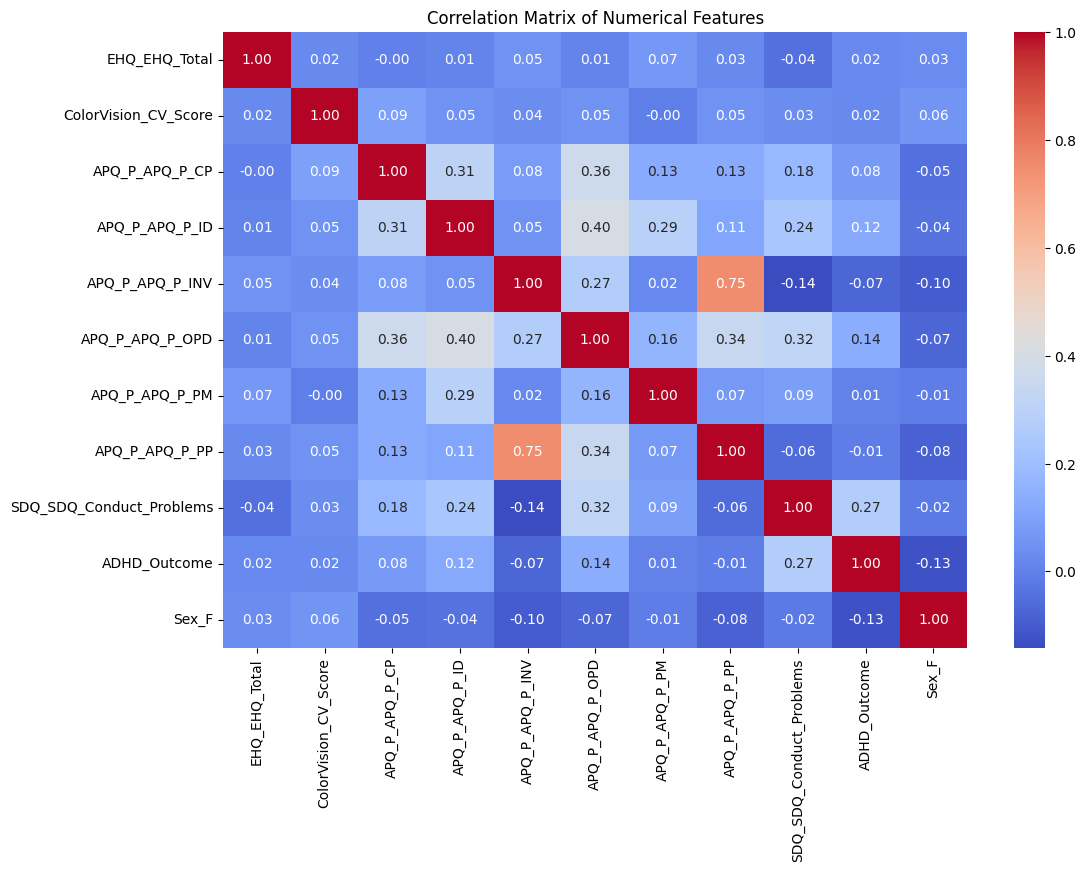

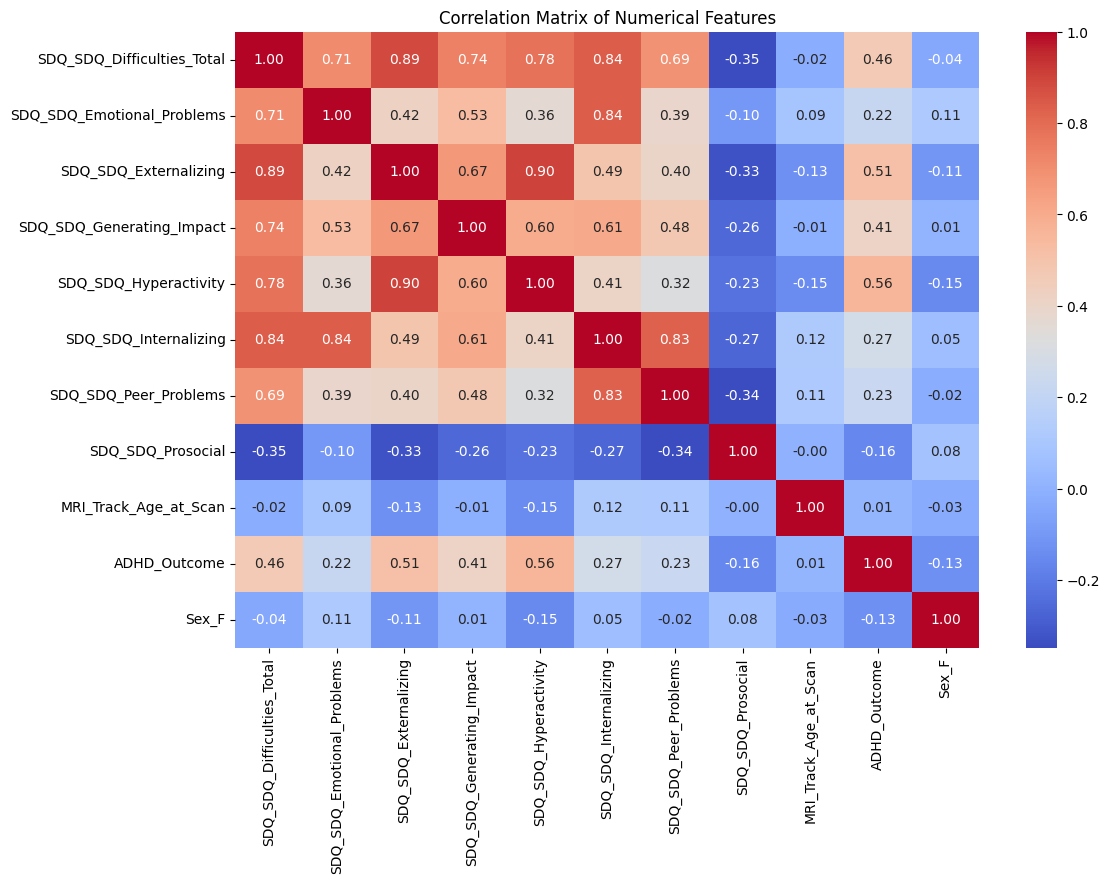

In [31]:
def corelation_analysis(data_combined, labels, numerical_cols, first_half = None):
    data_combined_with_labels = pd.merge(data_combined, labels, left_index=True, right_index=True, how="left")
    numerical_cols = list(numerical_cols)
    
    # Limit to the first half numerical columns (if more than half)
    if first_half is not None:
        threshold = int(len(numerical_cols)/2)
        if first_half is True:
            numerical_cols = numerical_cols[:threshold]
        else:
            numerical_cols = numerical_cols[threshold:]
    numerical_cols = numerical_cols + ["ADHD_Outcome", "Sex_F"]
    
    # Correlation heatmap for numerical features
    correlation_matrix = data_combined_with_labels[numerical_cols].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix of Numerical Features")
    plt.show()

for first_half in [True, False]:
    corelation_analysis(data_combined_without_functional, labels, numerical_cols_without_functional, first_half)

### **Observations**
The following predictors are not correlated with either **ADHD_Outcome** or **Sex_F**, and therefore can be dropped:
"**Basic_Demos_Study_Site**", "**MRI_Track_Scan_Location**", "**PreInt_Demos_Fam_Child_Ethnicity**", "**PreInt_Demos_Fam_Child_Race**", "**Barratt_Barratt_P1_Occ**", '**Barratt_Barratt_P2_Occ**".

### **Visualizing the Data**
Visualizing the relationship between features and target variables can provide deeper insights. Here are a few ideas for visualizations:

Boxplots/Histograms: To explore the distribution of numerical features.
Count Plots: For categorical variables, like Sex_F and ADHD_Outcome.

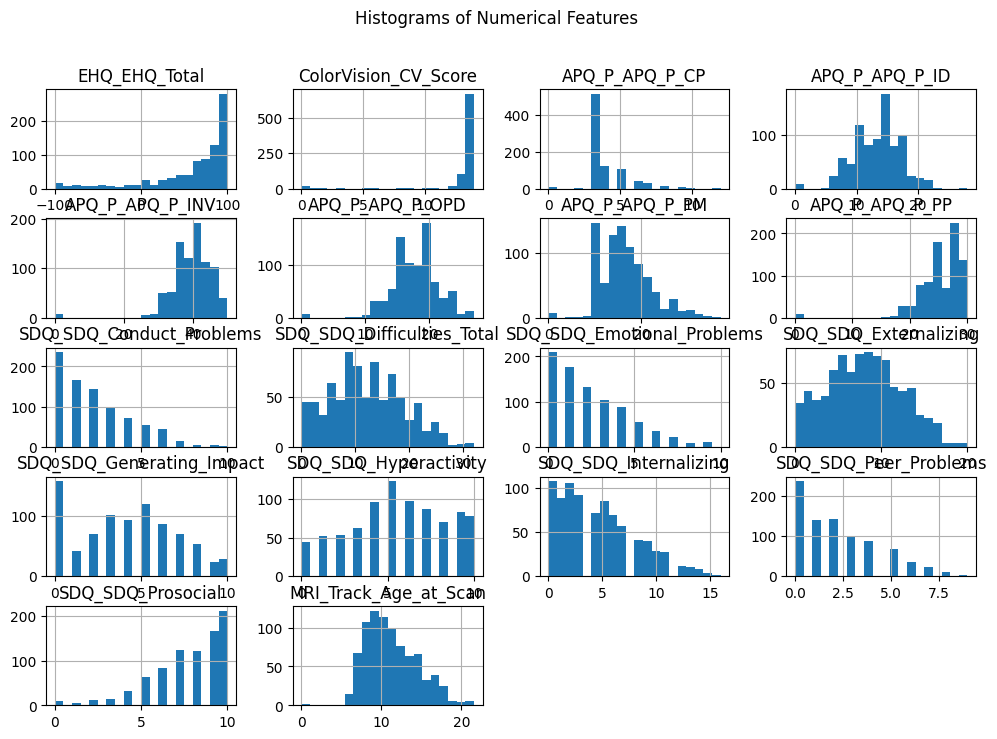

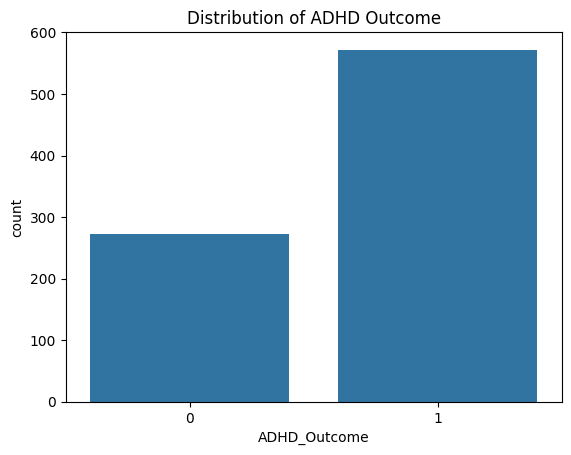

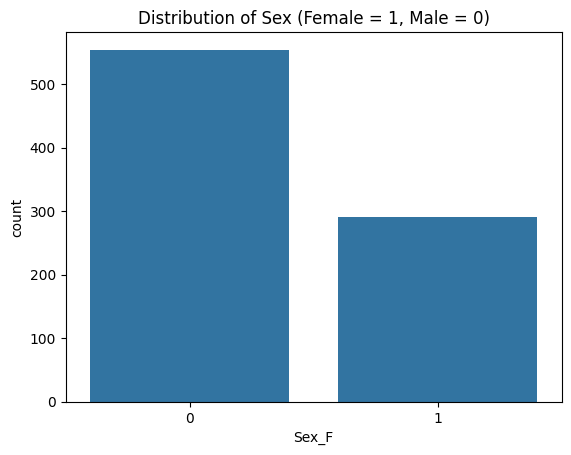

In [32]:
# Visualize the distribution of numerical features
data_combined_without_functional[numerical_cols_without_functional].hist(bins=20, figsize=(12, 8))
plt.suptitle("Histograms of Numerical Features")
plt.show()

# Visualize the distribution of ADHD_Outcome from the labels DataFrame
sns.countplot(x='ADHD_Outcome', data=labels)
plt.title('Distribution of ADHD Outcome')
plt.show()

# Visualize the distribution of Sex_F from the labels DataFrame
sns.countplot(x='Sex_F', data=labels)
plt.title('Distribution of Sex (Female = 1, Male = 0)')
plt.show()

## **Data Processing**

### **Treating Outliers**
Check for outliers and if found, handle them as following:
Calculate the lower whisker and upper whisker for each numerical column and replace any smaller value than lower whisker with lower whisker, and any larger value than upper whisker with upper whisker. Only print the number of outliers.

In [33]:
def treating_outliers(data, num_columns):
    outliers_info = {}  # Dictionary to track outliers removed for each column
    total_outliers = 0  # To track total outliers across all columns
    
    # Iterate over numerical columns
    for num_column in num_columns:
        # Get whisker for each column
        lower_whisker, upper_whisker = get_whiskers_by_column(data, num_column)

        # Identify outliers before replacing
        lower_outliers = data[data[num_column] < lower_whisker]
        upper_outliers = data[data[num_column] > upper_whisker]
        
        # Count outliers
        num_lower_outliers = len(lower_outliers)
        num_upper_outliers = len(upper_outliers)

        # Sum total outliers for all columns
        total_outliers += num_lower_outliers + num_upper_outliers

        # Print outliers info if any outliers exist
        if num_lower_outliers > 0 or num_upper_outliers > 0:
            print(f"Outliers for column '{num_column}':")
            print(f"  - Number of lower outliers: {num_lower_outliers}")
            print(f"  - Number of upper outliers: {num_upper_outliers}")

        # Replace values smaller than lower_whisker with lower_whisker, 
        # and values larger than upper_whisker with upper_whisker using clip method
        data[num_column] = data[num_column].clip(lower=lower_whisker, upper=upper_whisker)
        
        # Store outliers info in dictionary for potential future reference
        outliers_info[num_column] = {
            'lower_outliers': lower_outliers,
            'upper_outliers': upper_outliers,
            'num_lower_outliers': num_lower_outliers,
            'num_upper_outliers': num_upper_outliers
        }

    print("\nTotal number of outliers across all columns:", total_outliers)
    return data, outliers_info

# num_columns = [col for col in data_combined.select_dtypes(include=['float64', 'int64']).columns]
# data_combined, outliers_info = treating_outliers(data_combined, num_columns)

### **Split data into training and testing**
- Split the data into 80% training and 20% testing, and stratify based on male or female ('Sex_F') from the labels variable. 
- Set a random_state, so that it will generate the same random output each time. This controls the seed for the random number generator.

In [34]:
# Renamed labels and data_combined into Y and X
Y = labels
X = data_combined

# Define 2 targets
labels_adhd = labels["ADHD_Outcome"]
labels_sex = labels["Sex_F"]

# Splitting the data and stratify based on ADHD_Outcome
x_train_adhd, x_test_adhd, y_train_adhd, y_test_adhd = train_test_split(X, labels_adhd, test_size = 0.2, 
                                                                        random_state = 1, stratify = labels_adhd)
# Splitting the data and stratify based on Sex_F
x_train_sex, x_test_sex, y_train_sex, y_test_sex = train_test_split(X, labels_sex, test_size = 0.2, 
                                                                    random_state = 1, stratify = labels_sex)

In [35]:
def display_dataframe_shapes():
    shapes_list = [
        (x_train_adhd, 'x_train_adhd'),  
        (x_test_adhd, 'x_test_adhd'),  
        (y_train_adhd, 'y_train_adhd'),  
        (y_test_adhd, 'y_test_adhd'),  
        (x_train_sex, 'x_train_sex'),  
        (x_test_sex, 'x_test_sex'),  
        (y_train_sex, 'y_train_sex'),  
        (y_test_sex, 'y_test_sex'),  
    ]
    for item, name in shapes_list:
        print(f"{name}.shape: {item.shape}")
        
display_dataframe_shapes()

x_train_adhd.shape: (676, 19977)
x_test_adhd.shape: (169, 19977)
y_train_adhd.shape: (676,)
y_test_adhd.shape: (169,)
x_train_sex.shape: (676, 19977)
x_test_sex.shape: (169, 19977)
y_train_sex.shape: (676,)
y_test_sex.shape: (169,)


## **Model Building**

In [36]:
def metrics(y_pred, x_train, y_train, x_test, y_test, target_names):
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    return accuracy, precision, recall, f1

## Cross Validtion

In [37]:
def k_fold_cross_validation(x_train, y_train, model_constructor, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Lists to store performance metrics across folds
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    roc_aucs = []
    
    print(f"Performing {n_splits}-fold cross-validation...")
    
    # Iterate through folds
    for fold, (train_idx, val_idx) in enumerate(skf.split(x_train, y_train)):
        # Split data for this fold
        X_fold_train = x_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = x_train.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # Create a fresh model for each fold
        model = model_constructor()
        
        # Train model
        model.fit(X_fold_train, y_fold_train)
        
        # Evaluate on validation set
        y_pred = model.predict(X_fold_val)
        
        # Calculate metrics for this fold
        accuracies.append(accuracy_score(y_fold_val, y_pred))
        precisions.append(precision_score(y_fold_val, y_pred))
        recalls.append(recall_score(y_fold_val, y_pred))
        f1_scores.append(f1_score(y_fold_val, y_pred))
        
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_fold_val)[:, 1]
            roc_aucs.append(roc_auc_score(y_fold_val, y_proba))
        
        print(f"  Fold {fold+1}/{n_splits} - Accuracy: {accuracies[-1]:.4f}, F1: {f1_scores[-1]:.4f}")
    
    # Print summary statistics
    print("\nCross-validation results:")
    print(f"  Accuracy:  {np.mean(accuracies):.4f} (±{np.std(accuracies):.4f})")
    print(f"  Precision: {np.mean(precisions):.4f} (±{np.std(precisions):.4f})")
    print(f"  Recall:    {np.mean(recalls):.4f} (±{np.std(recalls):.4f})")
    print(f"  F1 score:  {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})")
    if roc_aucs:
        print(f"  ROC AUC:   {np.mean(roc_aucs):.4f} (±{np.std(roc_aucs):.4f})")

### **Logistic Regression**

### **Regular**

### ADHD_Outcome

Performing 10-fold cross-validation...
  Fold 1/10 - Accuracy: 0.7647, F1: 0.8182
  Fold 2/10 - Accuracy: 0.7647, F1: 0.8298
  Fold 3/10 - Accuracy: 0.8382, F1: 0.8911
  Fold 4/10 - Accuracy: 0.8529, F1: 0.8936
  Fold 5/10 - Accuracy: 0.8088, F1: 0.8713
  Fold 6/10 - Accuracy: 0.7500, F1: 0.8046
  Fold 7/10 - Accuracy: 0.8209, F1: 0.8696
  Fold 8/10 - Accuracy: 0.8060, F1: 0.8660
  Fold 9/10 - Accuracy: 0.7313, F1: 0.8085
  Fold 10/10 - Accuracy: 0.7463, F1: 0.8046

Cross-validation results:
  Accuracy:  0.7884 (±0.0401)
  Precision: 0.8318 (±0.0304)
  Recall:    0.8644 (±0.0720)
  F1 score:  0.8457 (±0.0343)
  ROC AUC:   0.8426 (±0.0404)

Training final model on full training set...
Accuracy: 0.7870
Precision: 0.8250
Recall: 0.8684
F1 Score: 0.8462

Confusion Matrix:
[[34 21]
 [15 99]]

Classification Report:
              precision    recall  f1-score   support

          No       0.69      0.62      0.65        55
         Yes       0.82      0.87      0.85       114

    accuracy  

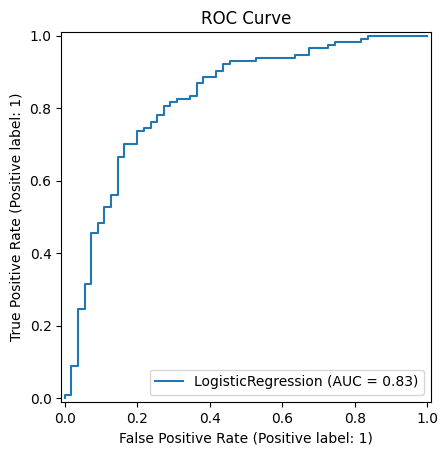

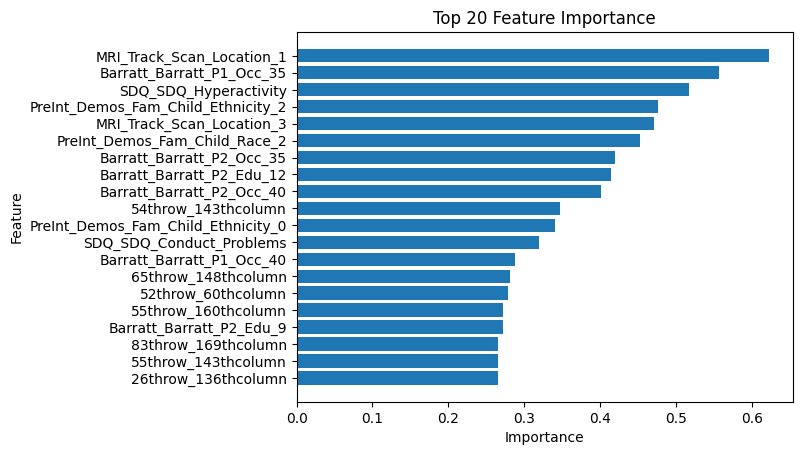

Model saved as lr_model_cv_adhd.joblib


### Sex_F

Performing 10-fold cross-validation...
  Fold 1/10 - Accuracy: 0.6471, F1: 0.4000
  Fold 2/10 - Accuracy: 0.7353, F1: 0.5500
  Fold 3/10 - Accuracy: 0.7206, F1: 0.5366
  Fold 4/10 - Accuracy: 0.6912, F1: 0.4878
  Fold 5/10 - Accuracy: 0.6618, F1: 0.4889
  Fold 6/10 - Accuracy: 0.6912, F1: 0.4878
  Fold 7/10 - Accuracy: 0.7761, F1: 0.6341
  Fold 8/10 - Accuracy: 0.6866, F1: 0.4615
  Fold 9/10 - Accuracy: 0.6418, F1: 0.4286
  Fold 10/10 - Accuracy: 0.6716, F1: 0.5217

Cross-validation results:
  Accuracy:  0.6923 (±0.0396)
  Precision: 0.5726 (±0.0805)
  Recall:    0.4467 (±0.0634)
  F1 score:  0.4997 (±0.0627)
  ROC AUC:   0.7189 (±0.0394)

Training final model on full training set...
Accuracy: 0.7219
Precision: 0.6410
Recall: 0.4310
F1 Score: 0.5155

Confusion Matrix:
[[97 14]
 [33 25]]

Classification Report:
              precision    recall  f1-score   support

        Male       0.75      0.87      0.80       111
      Female       0.64      0.43      0.52        58

    accuracy  

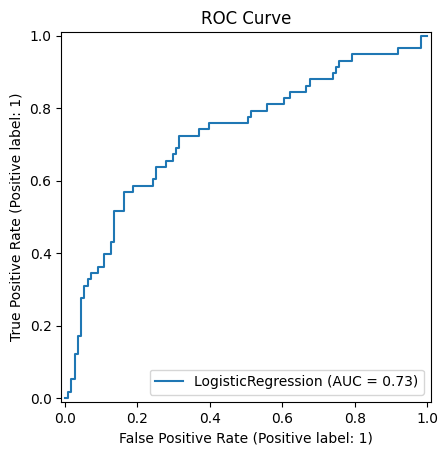

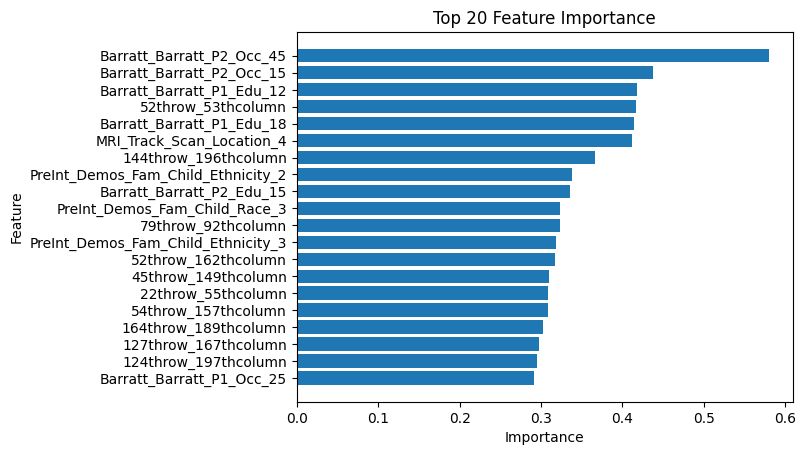

Model saved as lr_model_cv_sex.joblib


In [38]:
def fit_predict_and_metrics(x_train, y_train, x_test, y_test, target_names, model):
    model.fit(x_train, y_train)  # Train the model on the training data
    
    # Make predictions
    y_pred = model.predict(x_test)  # Use the trained model to make predictions on the test set
    
    # Display metrics
    metrics(y_pred, x_train, y_train, x_test, y_test, target_names)
    
    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, x_test, y_test)
    plt.title('ROC Curve')
    plt.show()
    
    # Plot top 20 feature importance
    if hasattr(model, 'coef_'):
        feature_importance = np.abs(model.coef_[0])
    elif hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
    else:
        raise ValueError("Model does not have feature importance or coefficients.")
    
    feature_names = x_train.columns
    top_20_indices = np.argsort(feature_importance)[-20:]  # Get indices of top 20 features
    top_20_features = feature_names[top_20_indices]
    top_20_importance = feature_importance[top_20_indices]
    
    plt.barh(top_20_features, top_20_importance)
    plt.title('Top 20 Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

def save_model(prefix, model_type, model):
    model_filename = prefix + "_" + model_type + ".joblib"  
    joblib.dump(model, model_filename)
    print(f"Model saved as {model_filename}")

def logistic_regression_with_cv(x_train, y_train, x_test, y_test, target_names, model_type, n_splits=10):
    # Cross-validation 
    def model_constructor():
        return LogisticRegression(class_weight='balanced', max_iter=1000)
    
    # Run cross-validation
    k_fold_cross_validation(x_train, y_train, model_constructor, n_splits=n_splits)
    
    # Train final model on all training data
    print("\nTraining final model on full training set...")
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    
    # Fit, predict, display metrics
    fit_predict_and_metrics(x_train, y_train, x_test, y_test, target_names, model)
    
    save_model("lr_model_cv", model_type, model)
    
    return model

def launch_model_building(model_building_function):
    display(Markdown('### ADHD_Outcome'))
    model_building_function(x_train_adhd, y_train_adhd, x_test_adhd, y_test_adhd, target_names=['No', 'Yes'], model_type="adhd")
    
    display(Markdown('### Sex_F'))
    model_building_function(x_train_sex, y_train_sex, x_test_sex, y_test_sex, target_names=['Male', 'Female'], model_type="sex")

launch_model_building(logistic_regression_with_cv)

### Ridge Regularization

### ADHD_Outcome

Performing 10-fold cross-validation for Logistic Regression with l2 regularization (C=1.0)...
Performing 10-fold cross-validation...
  Fold 1/10 - Accuracy: 0.7647, F1: 0.8182
  Fold 2/10 - Accuracy: 0.7647, F1: 0.8298
  Fold 3/10 - Accuracy: 0.8382, F1: 0.8911
  Fold 4/10 - Accuracy: 0.8529, F1: 0.8936
  Fold 5/10 - Accuracy: 0.8088, F1: 0.8713
  Fold 6/10 - Accuracy: 0.7500, F1: 0.8046
  Fold 7/10 - Accuracy: 0.8209, F1: 0.8696
  Fold 8/10 - Accuracy: 0.8060, F1: 0.8660
  Fold 9/10 - Accuracy: 0.7313, F1: 0.8085
  Fold 10/10 - Accuracy: 0.7463, F1: 0.8046

Cross-validation results:
  Accuracy:  0.7884 (±0.0401)
  Precision: 0.8318 (±0.0304)
  Recall:    0.8644 (±0.0720)
  F1 score:  0.8457 (±0.0343)
  ROC AUC:   0.8426 (±0.0404)

Training final model on full training set...
Accuracy: 0.7870
Precision: 0.8250
Recall: 0.8684
F1 Score: 0.8462

Confusion Matrix:
[[34 21]
 [15 99]]

Classification Report:
              precision    recall  f1-score   support

          No       0.69      

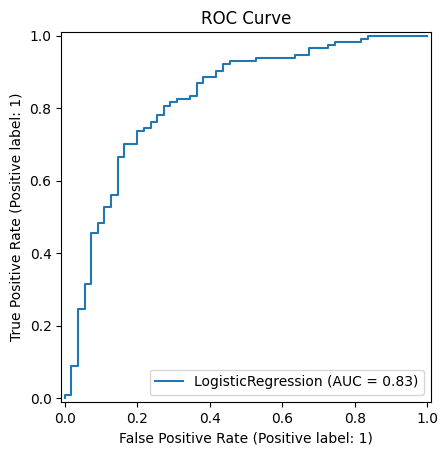

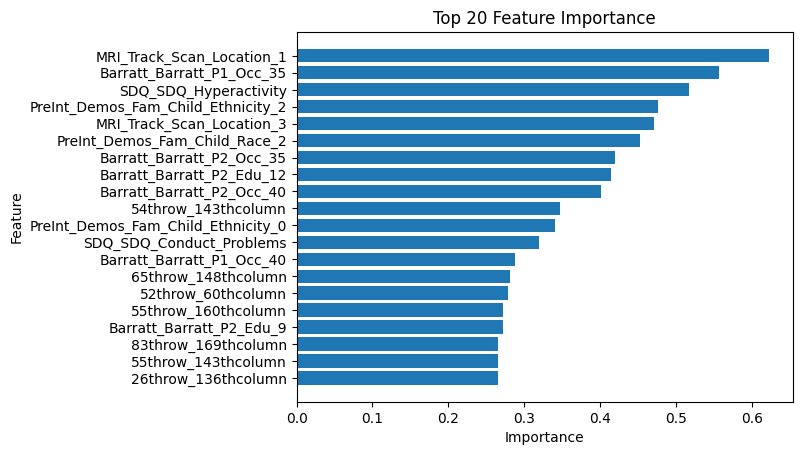

Model saved as lr_model_ridge_C1.0_adhd.joblib


### Sex_F

Performing 10-fold cross-validation for Logistic Regression with l2 regularization (C=1.0)...
Performing 10-fold cross-validation...
  Fold 1/10 - Accuracy: 0.6471, F1: 0.4000
  Fold 2/10 - Accuracy: 0.7353, F1: 0.5500
  Fold 3/10 - Accuracy: 0.7206, F1: 0.5366
  Fold 4/10 - Accuracy: 0.6912, F1: 0.4878
  Fold 5/10 - Accuracy: 0.6618, F1: 0.4889
  Fold 6/10 - Accuracy: 0.6912, F1: 0.4878
  Fold 7/10 - Accuracy: 0.7761, F1: 0.6341
  Fold 8/10 - Accuracy: 0.6866, F1: 0.4615
  Fold 9/10 - Accuracy: 0.6418, F1: 0.4286
  Fold 10/10 - Accuracy: 0.6716, F1: 0.5217

Cross-validation results:
  Accuracy:  0.6923 (±0.0396)
  Precision: 0.5726 (±0.0805)
  Recall:    0.4467 (±0.0634)
  F1 score:  0.4997 (±0.0627)
  ROC AUC:   0.7189 (±0.0394)

Training final model on full training set...
Accuracy: 0.7219
Precision: 0.6410
Recall: 0.4310
F1 Score: 0.5155

Confusion Matrix:
[[97 14]
 [33 25]]

Classification Report:
              precision    recall  f1-score   support

        Male       0.75      

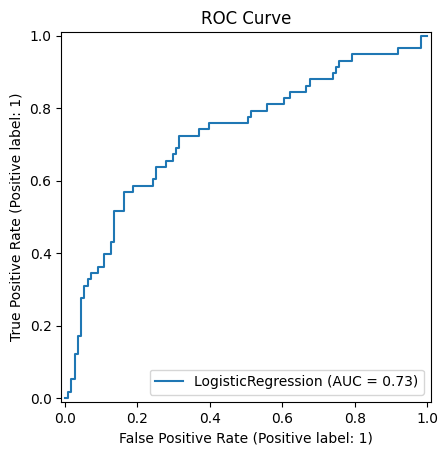

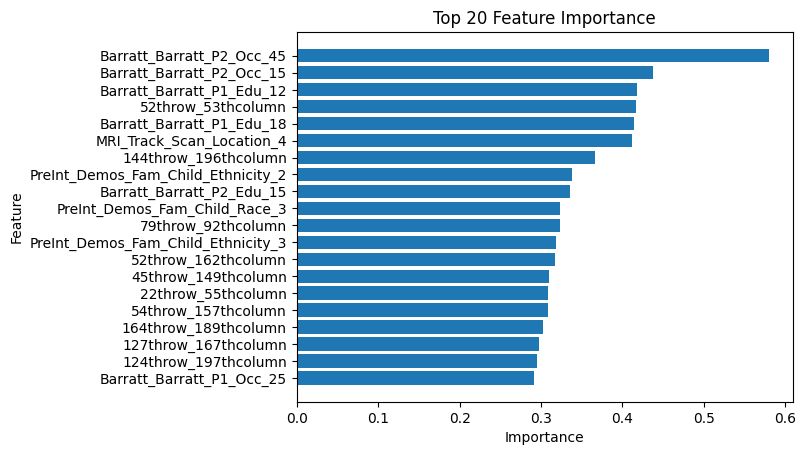

Model saved as lr_model_ridge_C1.0_sex.joblib


In [39]:
# Logistic Regression with Ridge (L2) Regularization + Cross-Validation
def logistic_regression_with_ridge_cv(x_train, y_train, x_test, y_test, target_names, model_type, penalty='l2', C=1.0, n_splits=10):
    # Cross-validation 
    def model_constructor():
        return LogisticRegression(class_weight='balanced', max_iter=1000, penalty=penalty, C=C)
    
    # Run cross-validation
    print(f"Performing {n_splits}-fold cross-validation for Logistic Regression with {penalty} regularization (C={C})...")
    k_fold_cross_validation(x_train, y_train, model_constructor, n_splits=n_splits)
    
    # Train final model on all training data
    print("\nTraining final model on full training set...")
    model = LogisticRegression(class_weight='balanced', max_iter=1000, penalty=penalty, C=C)  # Logistic Regression with regularization
    
    # Fit, predict, display metrics
    fit_predict_and_metrics(x_train, y_train, x_test, y_test, target_names, model)
    
    save_model(f"lr_model_ridge_C{C}", model_type, model)
    
    return model

launch_model_building(lambda x_train, y_train, x_test, y_test, target_names, model_type: 
                     logistic_regression_with_ridge_cv(x_train, y_train, x_test, y_test, target_names, model_type))

## Hyperparameter Tuning for Ridge Regularization

### ADHD_Outcome

Evaluating 5 different C values...

C Value Comparison:
C Value    Accuracy   F1 Score  
------------------------------
0.01       0.7929     0.8402
0.1        0.7811     0.8384
1.0        0.7870     0.8462
10.0       0.7988     0.8559
100.0      0.8047     0.8608

 Best C value: 100.0 with F1 score: 0.8608

--- Detailed evaluation for best model (C=100.0) ---
Performing 10-fold cross-validation for Logistic Regression with l2 regularization (C=100.0)...
Performing 10-fold cross-validation...
  Fold 1/10 - Accuracy: 0.7500, F1: 0.8090
  Fold 2/10 - Accuracy: 0.7647, F1: 0.8298
  Fold 3/10 - Accuracy: 0.8382, F1: 0.8911
  Fold 4/10 - Accuracy: 0.8529, F1: 0.8936
  Fold 5/10 - Accuracy: 0.8088, F1: 0.8713
  Fold 6/10 - Accuracy: 0.7941, F1: 0.8444
  Fold 7/10 - Accuracy: 0.8209, F1: 0.8750
  Fold 8/10 - Accuracy: 0.7910, F1: 0.8571
  Fold 9/10 - Accuracy: 0.7463, F1: 0.8211
  Fold 10/10 - Accuracy: 0.7463, F1: 0.8046

Cross-validation results:
  Accuracy:  0.7913 (±0.0370)
  Precision: 0

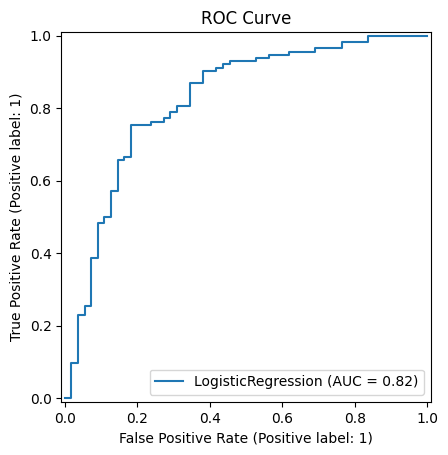

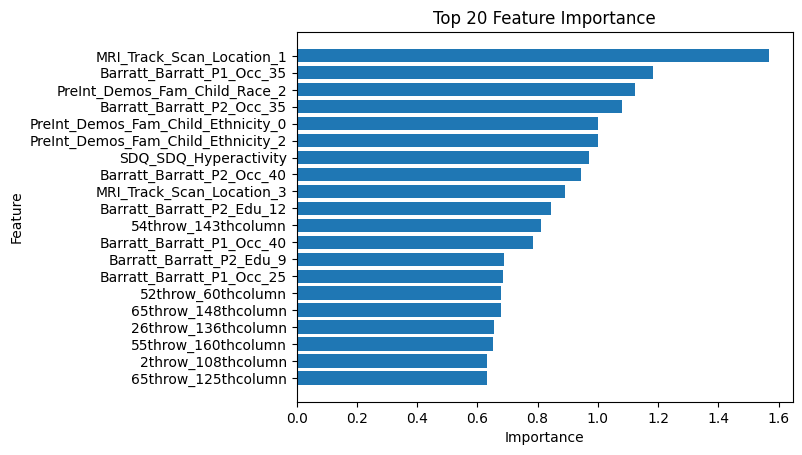

Model saved as lr_model_ridge_C100.0_adhd.joblib


### Sex_F

Evaluating 5 different C values...

C Value Comparison:
C Value    Accuracy   F1 Score  
------------------------------
0.01       0.6746     0.5455
0.1        0.7278     0.5490
1.0        0.7219     0.5155
10.0       0.7278     0.5106
100.0      0.7278     0.5106

 Best C value: 0.1 with F1 score: 0.5490

--- Detailed evaluation for best model (C=0.1) ---
Performing 10-fold cross-validation for Logistic Regression with l2 regularization (C=0.1)...
Performing 10-fold cross-validation...
  Fold 1/10 - Accuracy: 0.6324, F1: 0.4681
  Fold 2/10 - Accuracy: 0.7059, F1: 0.5238
  Fold 3/10 - Accuracy: 0.6912, F1: 0.5532
  Fold 4/10 - Accuracy: 0.6912, F1: 0.5116
  Fold 5/10 - Accuracy: 0.6471, F1: 0.5000
  Fold 6/10 - Accuracy: 0.6765, F1: 0.4762
  Fold 7/10 - Accuracy: 0.7612, F1: 0.6364
  Fold 8/10 - Accuracy: 0.7463, F1: 0.6222
  Fold 9/10 - Accuracy: 0.6119, F1: 0.4091
  Fold 10/10 - Accuracy: 0.6866, F1: 0.5532

Cross-validation results:
  Accuracy:  0.6850 (±0.0444)
  Precision: 0.5484 

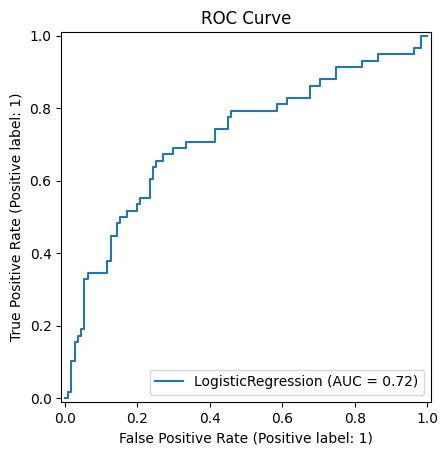

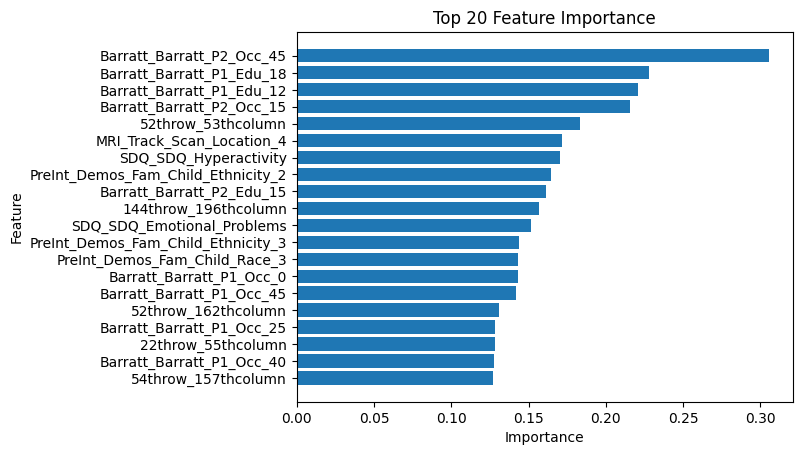

Model saved as lr_model_ridge_C0.1_sex.joblib


In [40]:
def try_different_c_values(x_train, y_train, x_test, y_test, target_names, model_type):
    c_values = [0.01, 0.1, 1.0, 10.0, 100.0]
    best_c = None
    best_f1 = 0
    best_model = None
    
    # Find the best C value
    print(f"Evaluating {len(c_values)} different C values...")
    results = []
    
    for c in c_values:
        # Create model with current C value (no cross-validation)
        model = LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l2', C=c)
        model.fit(x_train, y_train)
        
        # Quick test set evaluation
        y_pred = model.predict(x_test)
        current_f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        
        results.append({"C": c, "F1": current_f1, "Accuracy": accuracy})
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_c = c
    
    # Display summary table of all C values
    print("\nC Value Comparison:")
    print(f"{'C Value':<10} {'Accuracy':<10} {'F1 Score':<10}")
    print("-" * 30)
    for result in results:
        print(f"{result['C']:<10} {result['Accuracy']:.4f}     {result['F1']:.4f}")
    
    print(f"\n Best C value: {best_c} with F1 score: {best_f1:.4f}")
    
    # Full cross-validation only for the best C value
    print(f"\n--- Detailed evaluation for best model (C={best_c}) ---")
    best_model = logistic_regression_with_ridge_cv(
        x_train, y_train, x_test, y_test, 
        target_names, model_type, 
        penalty='l2', C=best_c
    )
    
    return best_c, best_model

launch_model_building(try_different_c_values)

### Lasso Regularization

### ADHD_Outcome

Performing 10-fold cross-validation for Logistic Regression with L1 regularization (C=1.0)...
Performing 10-fold cross-validation...
  Fold 1/10 - Accuracy: 0.7647, F1: 0.8095
  Fold 2/10 - Accuracy: 0.7647, F1: 0.8261
  Fold 3/10 - Accuracy: 0.8676, F1: 0.9072
  Fold 4/10 - Accuracy: 0.7794, F1: 0.8276
  Fold 5/10 - Accuracy: 0.7206, F1: 0.8000
  Fold 6/10 - Accuracy: 0.7500, F1: 0.8046
  Fold 7/10 - Accuracy: 0.7910, F1: 0.8444
  Fold 8/10 - Accuracy: 0.7910, F1: 0.8511
  Fold 9/10 - Accuracy: 0.6269, F1: 0.7191
  Fold 10/10 - Accuracy: 0.7313, F1: 0.7857

Cross-validation results:
  Accuracy:  0.7587 (±0.0584)
  Precision: 0.8361 (±0.0476)
  Recall:    0.8031 (±0.0701)
  F1 score:  0.8175 (±0.0462)
  ROC AUC:   0.8229 (±0.0529)

Training final model on full training set...
Accuracy: 0.7988
Precision: 0.8571
Recall: 0.8421
F1 Score: 0.8496

Confusion Matrix:
[[39 16]
 [18 96]]

Classification Report:
              precision    recall  f1-score   support

          No       0.68      

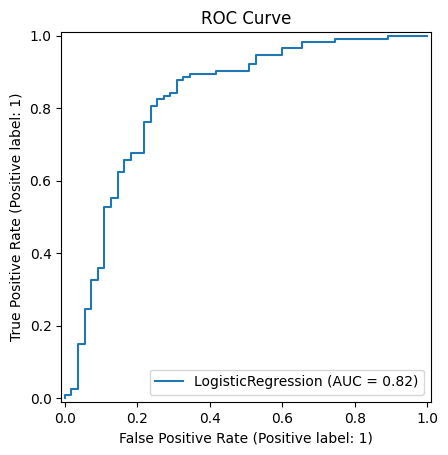

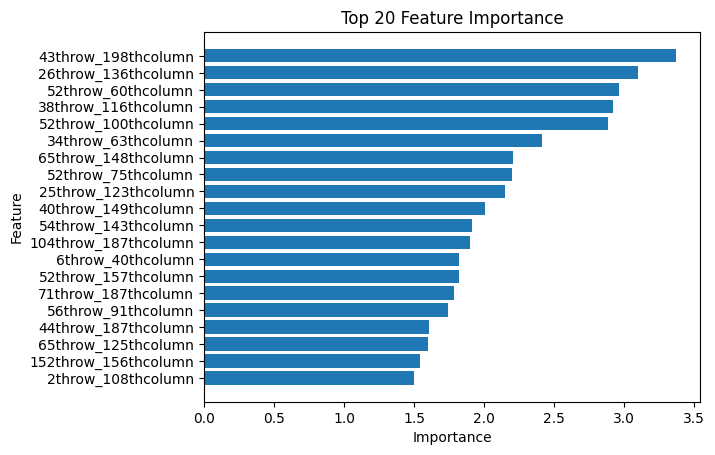

Model saved as lr_model_lasso_C1.0_adhd.joblib


### Sex_F

Performing 10-fold cross-validation for Logistic Regression with L1 regularization (C=1.0)...
Performing 10-fold cross-validation...
  Fold 1/10 - Accuracy: 0.6029, F1: 0.4490
  Fold 2/10 - Accuracy: 0.6765, F1: 0.5217
  Fold 3/10 - Accuracy: 0.6471, F1: 0.4545
  Fold 4/10 - Accuracy: 0.6029, F1: 0.4490
  Fold 5/10 - Accuracy: 0.5294, F1: 0.4074
  Fold 6/10 - Accuracy: 0.5882, F1: 0.4167
  Fold 7/10 - Accuracy: 0.5522, F1: 0.4231
  Fold 8/10 - Accuracy: 0.6418, F1: 0.4783
  Fold 9/10 - Accuracy: 0.6269, F1: 0.4898
  Fold 10/10 - Accuracy: 0.5821, F1: 0.5000

Cross-validation results:
  Accuracy:  0.6050 (±0.0425)
  Precision: 0.4407 (±0.0545)
  Recall:    0.4853 (±0.0500)
  F1 score:  0.4589 (±0.0359)
  ROC AUC:   0.6099 (±0.0485)

Training final model on full training set...
Accuracy: 0.6805
Precision: 0.5357
Recall: 0.5172
F1 Score: 0.5263

Confusion Matrix:
[[85 26]
 [28 30]]

Classification Report:
              precision    recall  f1-score   support

        Male       0.75      

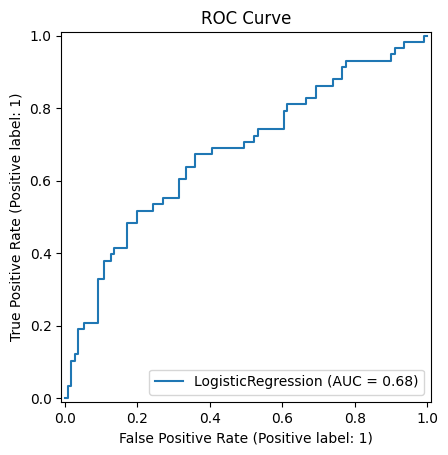

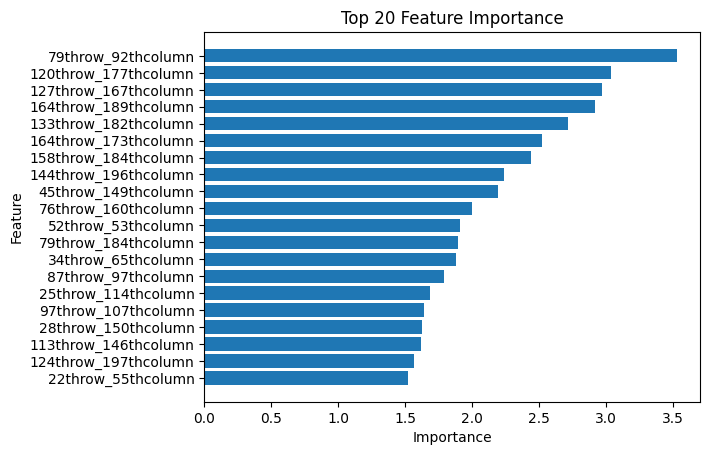

Model saved as lr_model_lasso_C1.0_sex.joblib


In [41]:
# Logistic Regression with Lasso (L1) Regularization + Cross-Validation
def logistic_regression_with_lasso_cv(x_train, y_train, x_test, y_test, target_names, model_type, C=1.0, n_splits=10):
    # Cross-validation 
    def model_constructor():
        return LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1', C=C, solver='liblinear')
    
    # Run cross-validation
    print(f"Performing {n_splits}-fold cross-validation for Logistic Regression with L1 regularization (C={C})...")
    k_fold_cross_validation(x_train, y_train, model_constructor, n_splits=n_splits)
    
    # Train final model on all training data
    print("\nTraining final model on full training set...")
    model = LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1', C=C, solver='liblinear')  # Lasso (L1) regularization
    
    # Fit, predict, display metrics
    fit_predict_and_metrics(x_train, y_train, x_test, y_test, target_names, model)
    
    save_model(f"lr_model_lasso_C{C}", model_type, model)
    
    return model

launch_model_building(lambda x_train, y_train, x_test, y_test, target_names, model_type: 
                     logistic_regression_with_lasso_cv(x_train, y_train, x_test, y_test, target_names, model_type))

## Hyperparameter Tuning for Lasso Regularization

### ADHD_Outcome

Evaluating 5 different C values for Lasso regularization...

Lasso C Value Comparison:
C Value    Accuracy   F1 Score   Non-zero Features
--------------------------------------------------
0.001      0.6805     0.8085     1
0.01       0.7515     0.8091     6
0.1        0.7633     0.8165     14
1.0        0.7988     0.8496     140
10.0       0.7751     0.8333     332

 Best C value: 1.0 with F1 score: 0.8496

--- Detailed evaluation for best Lasso model (C=1.0) ---
Performing 10-fold cross-validation for Logistic Regression with L1 regularization (C=1.0)...
Performing 10-fold cross-validation...
  Fold 1/10 - Accuracy: 0.7647, F1: 0.8095
  Fold 2/10 - Accuracy: 0.7647, F1: 0.8261
  Fold 3/10 - Accuracy: 0.8676, F1: 0.9072
  Fold 4/10 - Accuracy: 0.7794, F1: 0.8276
  Fold 5/10 - Accuracy: 0.7206, F1: 0.8000
  Fold 6/10 - Accuracy: 0.7500, F1: 0.8046
  Fold 7/10 - Accuracy: 0.7910, F1: 0.8444
  Fold 8/10 - Accuracy: 0.7910, F1: 0.8511
  Fold 9/10 - Accuracy: 0.6269, F1: 0.7191
  Fold 10/1

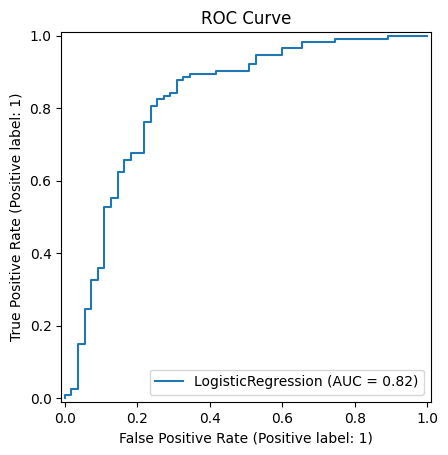

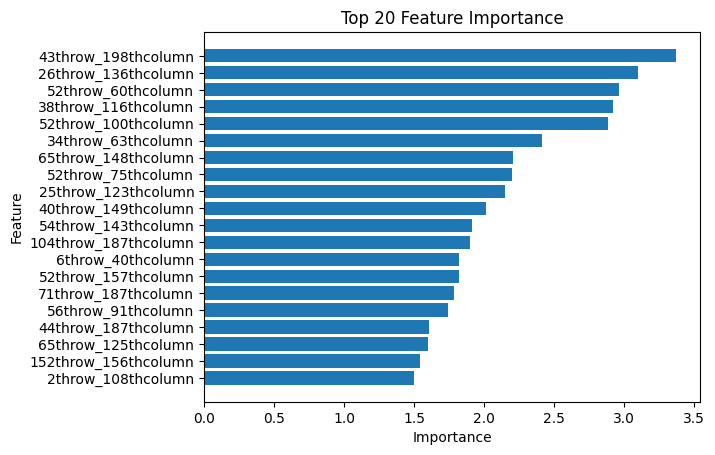

Model saved as lr_model_lasso_C1.0_adhd.joblib


### Sex_F

Evaluating 5 different C values for Lasso regularization...

Lasso C Value Comparison:
C Value    Accuracy   F1 Score   Non-zero Features
--------------------------------------------------
0.001      0.6568     0.0000     0
0.01       0.5740     0.4194     4
0.1        0.6272     0.5039     15
1.0        0.6805     0.5263     213
10.0       0.6686     0.4717     444

 Best C value: 1.0 with F1 score: 0.5263

--- Detailed evaluation for best Lasso model (C=1.0) ---
Performing 10-fold cross-validation for Logistic Regression with L1 regularization (C=1.0)...
Performing 10-fold cross-validation...
  Fold 1/10 - Accuracy: 0.6029, F1: 0.4490
  Fold 2/10 - Accuracy: 0.6765, F1: 0.5217
  Fold 3/10 - Accuracy: 0.6471, F1: 0.4545
  Fold 4/10 - Accuracy: 0.6029, F1: 0.4490
  Fold 5/10 - Accuracy: 0.5294, F1: 0.4074
  Fold 6/10 - Accuracy: 0.5882, F1: 0.4167
  Fold 7/10 - Accuracy: 0.5522, F1: 0.4231
  Fold 8/10 - Accuracy: 0.6418, F1: 0.4783
  Fold 9/10 - Accuracy: 0.6269, F1: 0.4898
  Fold 10/1

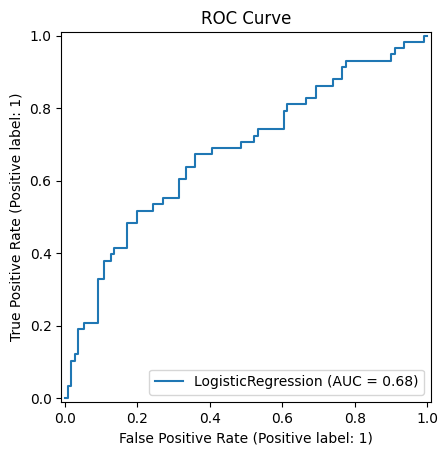

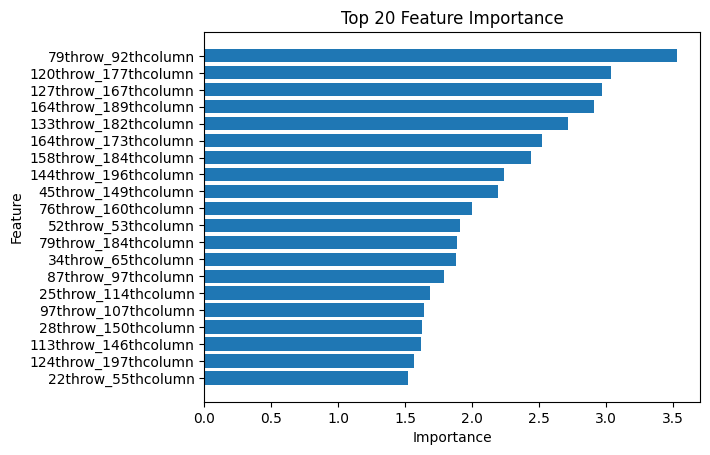

Model saved as lr_model_lasso_C1.0_sex.joblib


In [42]:
def try_different_lasso_c_values(x_train, y_train, x_test, y_test, target_names, model_type):
    c_values = [0.001, 0.01, 0.1, 1.0, 10.0]
    best_c = None
    best_f1 = 0
    best_model = None
    
    # Find the best C value
    print(f"Evaluating {len(c_values)} different C values for Lasso regularization...")
    results = []
    
    for c in c_values:
        # Create model with current C value (no cross-validation)
        model = LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1', C=c, solver='liblinear')
        model.fit(x_train, y_train)
        
        # Quick test set evaluation
        y_pred = model.predict(x_test)
        current_f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Count non-zero coefficients
        if hasattr(model, 'coef_'):
            n_features = (np.abs(model.coef_[0]) > 1e-5).sum()
        else:
            n_features = "N/A"
            
        results.append({
            "C": c, 
            "F1": current_f1, 
            "Accuracy": accuracy,
            "Features": n_features
        })
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_c = c
    
    # Display summary table of all C values
    print("\nLasso C Value Comparison:")
    print(f"{'C Value':<10} {'Accuracy':<10} {'F1 Score':<10} {'Non-zero Features':<15}")
    print("-" * 50)
    for result in results:
        print(f"{result['C']:<10} {result['Accuracy']:.4f}     {result['F1']:.4f}     {result['Features']}")
    
    print(f"\n Best C value: {best_c} with F1 score: {best_f1:.4f}")
    
    # Full cross-validation only for the best C value
    print(f"\n--- Detailed evaluation for best Lasso model (C={best_c}) ---")
    best_model = logistic_regression_with_lasso_cv(
        x_train, y_train, x_test, y_test, 
        target_names, model_type, 
        C=best_c
    )
    
    return best_c, best_model

launch_model_building(try_different_lasso_c_values)

### **Random Forest**

#### **Regular Random Forest**

### ADHD_Outcome

Performing 10-fold cross-validation...
  Fold 1/10 - Accuracy: 0.6765, F1: 0.8070
  Fold 2/10 - Accuracy: 0.6765, F1: 0.8070
  Fold 3/10 - Accuracy: 0.6765, F1: 0.8070
  Fold 4/10 - Accuracy: 0.6765, F1: 0.8070
  Fold 5/10 - Accuracy: 0.6765, F1: 0.8070
  Fold 6/10 - Accuracy: 0.6765, F1: 0.8070
  Fold 7/10 - Accuracy: 0.6866, F1: 0.8142
  Fold 8/10 - Accuracy: 0.6866, F1: 0.8142
  Fold 9/10 - Accuracy: 0.6716, F1: 0.8036
  Fold 10/10 - Accuracy: 0.6716, F1: 0.8036

Cross-validation results:
  Accuracy:  0.6775 (±0.0049)
  Precision: 0.6775 (±0.0049)
  Recall:    1.0000 (±0.0000)
  F1 score:  0.8078 (±0.0035)
  ROC AUC:   0.6583 (±0.0706)

Training final model on full training set...
Accuracy: 0.6746
Precision: 0.6746
Recall: 1.0000
F1 Score: 0.8057

Confusion Matrix:
[[  0  55]
 [  0 114]]

Classification Report:
              precision    recall  f1-score   support

          No       0.00      0.00      0.00        55
         Yes       0.67      1.00      0.81       114

    accura

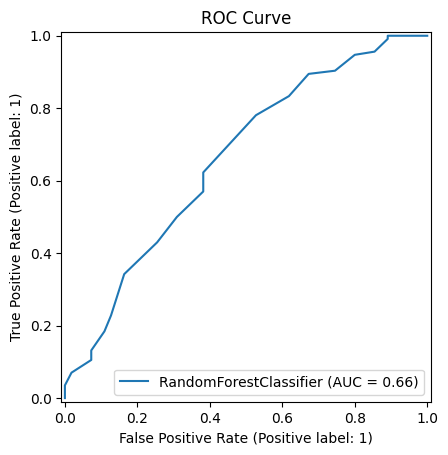

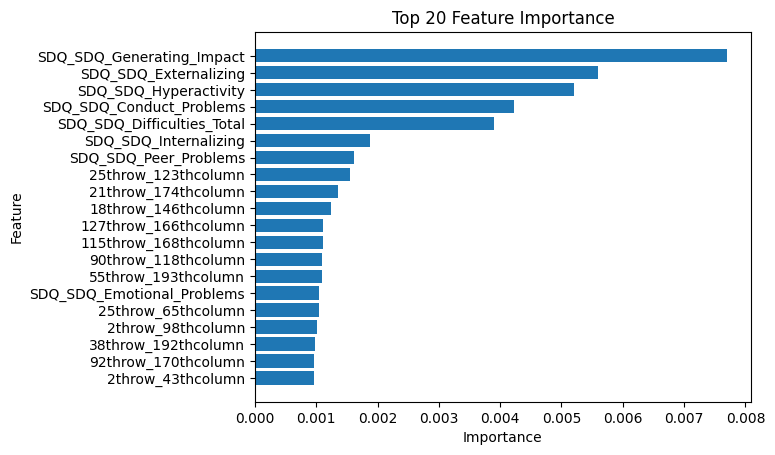

Model saved as rf_model_cv_adhd.joblib


### Sex_F

Performing 10-fold cross-validation...
  Fold 1/10 - Accuracy: 0.6471, F1: 0.0000
  Fold 2/10 - Accuracy: 0.6471, F1: 0.0000
  Fold 3/10 - Accuracy: 0.6471, F1: 0.0000
  Fold 4/10 - Accuracy: 0.6618, F1: 0.0000
  Fold 5/10 - Accuracy: 0.6618, F1: 0.0000
  Fold 6/10 - Accuracy: 0.6618, F1: 0.0000
  Fold 7/10 - Accuracy: 0.6567, F1: 0.0000
  Fold 8/10 - Accuracy: 0.6567, F1: 0.0000
  Fold 9/10 - Accuracy: 0.6567, F1: 0.0000
  Fold 10/10 - Accuracy: 0.6567, F1: 0.0000

Cross-validation results:
  Accuracy:  0.6553 (±0.0058)
  Precision: 0.0000 (±0.0000)
  Recall:    0.0000 (±0.0000)
  F1 score:  0.0000 (±0.0000)
  ROC AUC:   0.5151 (±0.1025)

Training final model on full training set...
Accuracy: 0.6568
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Confusion Matrix:
[[111   0]
 [ 58   0]]

Classification Report:
              precision    recall  f1-score   support

        Male       0.66      1.00      0.79       111
      Female       0.00      0.00      0.00        58

    accura

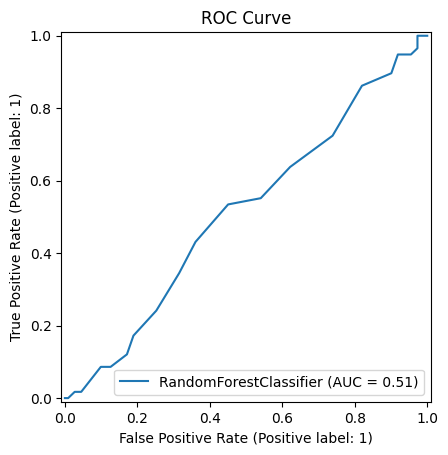

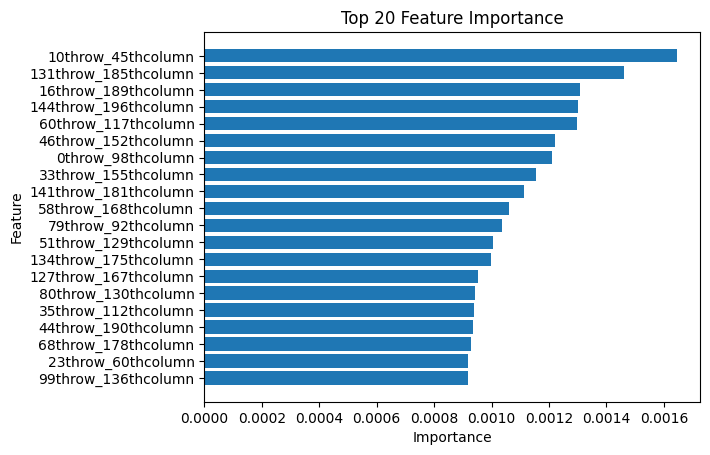

Model saved as rf_model_cv_sex.joblib


In [43]:
def random_forest_with_cv(x_train, y_train, x_test, y_test, target_names, model_type, n_splits=10):
    # Cross-validation 
    def model_constructor():
        return RandomForestClassifier(class_weight='balanced', random_state=42)
    
    # Run cross-validation
    k_fold_cross_validation(x_train, y_train, model_constructor, n_splits=n_splits)
    
    # Train final model on all training data
    print("\nTraining final model on full training set...")
    model = RandomForestClassifier(class_weight='balanced', random_state=42)
    
    # Fit, predict, display metrics
    fit_predict_and_metrics(x_train, y_train, x_test, y_test, target_names, model)
    
    save_model("rf_model_cv", model_type, model)
    
    return model

launch_model_building(random_forest_with_cv)

#### **Hyperparameter Tuning for Random Forest**

In [ ]:
def tune_random_forest(x_train, y_train, x_test, y_test, target_names, model_type):
    param_grid = [
        {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]},
    ]
    
    # Find best parameters without full cross-validation
    print(f"Evaluating {sum(len(d['n_estimators']) * len(d['max_depth']) * len(d['min_samples_split']) for d in param_grid)} different parameter combinations...")
    results = []
    
    best_f1 = 0
    best_params = None
    
    # Try each parameter combination
    for n_estimators in param_grid[0]['n_estimators']:
        for max_depth in param_grid[0]['max_depth']:
            for min_samples_split in param_grid[0]['min_samples_split']:
                # Create and train model
                model = RandomForestClassifier(
                    class_weight='balanced', 
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    random_state=42
                )
                model.fit(x_train, y_train)
                
                # Quick test set evaluation
                y_pred = model.predict(x_test)
                current_f1 = f1_score(y_test, y_pred)
                accuracy = accuracy_score(y_test, y_pred)
                
                params = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth if max_depth else "None",
                    'min_samples_split': min_samples_split
                }
                
                results.append({
                    "params": params,
                    "F1": current_f1,
                    "Accuracy": accuracy
                })
                
                if current_f1 > best_f1:
                    best_f1 = current_f1
                    best_params = params
    
    # Display summary table of top 5 parameter combinations
    print("\nTop 5 Parameter Combinations:")
    sorted_results = sorted(results, key=lambda x: x["F1"], reverse=True)[:5]
    
    print(f"{'n_estimators':<12} {'max_depth':<10} {'min_samples_split':<16} {'Accuracy':<10} {'F1 Score':<10}")
    print("-" * 60)
    for result in sorted_results:
        p = result["params"]
        print(f"{p['n_estimators']:<12} {p['max_depth']:<10} {p['min_samples_split']:<16} {result['Accuracy']:.4f}     {result['F1']:.4f}")

    if best_params is not None:
        print(f"\n Best parameters: n_estimators={best_params['n_estimators']}, max_depth={best_params['max_depth']}, "
              f"min_samples_split={best_params['min_samples_split']} with F1 score: {best_f1:.4f}")
    else:
        print("Best parameters not found.")
    
    # Full cross-validation only for the best parameters
    print(f"\n--- Detailed evaluation for best Random Forest model ---")
    
    # Cross-validation function with best parameters
    def random_forest_best_params_cv(x_train, y_train, x_test, y_test, target_names, model_type, n_splits=10):
        # Cross-validation 
        def model_constructor():
            return RandomForestClassifier(
                class_weight='balanced', 
                n_estimators=best_params['n_estimators'],
                max_depth=best_params['max_depth'] if best_params['max_depth'] != "None" else None,
                min_samples_split=best_params['min_samples_split'],
                random_state=42
            )
        
        # Run cross-validation
        print(f"Performing {n_splits}-fold cross-validation for Random Forest with best parameters...")
        k_fold_cross_validation(x_train, y_train, model_constructor, n_splits=n_splits)
        
        # Train final model on all training data
        print("\nTraining final model on full training set...")
        model = model_constructor()
        
        # Fit, predict, display metrics
        fit_predict_and_metrics(x_train, y_train, x_test, y_test, target_names, model)
        
        save_model("rf_model_tuned", model_type, model)
        
        return model
    
    # Run cross-validation with best parameters
    best_model = random_forest_best_params_cv(x_train, y_train, x_test, y_test, target_names, model_type)
    
    return best_params, best_model

launch_model_building(tune_random_forest)

### ADHD_Outcome

Evaluating 12 different parameter combinations...

Top 5 Parameter Combinations:
n_estimators max_depth  min_samples_split Accuracy   F1 Score  
------------------------------------------------------------
100          None       2                0.6746     0.8057
100          None       5                0.6746     0.8057
100          10         2                0.6746     0.8057
100          10         5                0.6746     0.8057
100          20         2                0.6746     0.8057

 Best parameters: n_estimators=100, max_depth=None, min_samples_split=2 with F1 score: 0.8057

--- Detailed evaluation for best Random Forest model ---
Performing 10-fold cross-validation for Random Forest with best parameters...
Performing 10-fold cross-validation...
  Fold 1/10 - Accuracy: 0.6765, F1: 0.8070
  Fold 2/10 - Accuracy: 0.6765, F1: 0.8070
  Fold 3/10 - Accuracy: 0.6765, F1: 0.8070
  Fold 4/10 - Accuracy: 0.6765, F1: 0.8070
  Fold 5/10 - Accuracy: 0.6765, F1: 0.8070
  Fold 6/10 - 

#### **Hyperparameter tuning**

In [ ]:
def tuned_random_forest(x_train, y_train, x_test, y_test, target_names, model_type):
    # Define the model
    model = RandomForestClassifier(class_weight='balanced', random_state=42)
    
    # Set a smaller parameters grid for faster tuning
    param_dist = {
        'n_estimators': [50, 100, 150],  # Limit number of trees
        'max_depth': [None, 10, 20],  # Limit depth of trees
        'min_samples_split': [2, 5],  # Lower minimum samples to split
        'min_samples_leaf': [1, 2],  # Lower minimum samples per leaf
        'bootstrap': [True],  # Use bootstrap sampling (True is generally best)
    }
    
    # Use RandomizedSearchCV for faster tuning with fewer iterations
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=5,  # Reduce the number of iterations for faster results
        cv=2,  # Reduce cross-validation folds to speed up the process
        n_jobs=-1,  # Use all available CPU cores
        verbose=2,  # Show progress
        scoring='accuracy',  # Evaluation metric
        random_state=42
    )
    
    # Fit the randomized search to the data (only a subset of the data if needed)
    random_search.fit(x_train, y_train)
    
    # Get the best parameters from RandomizedSearch
    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)
    
    # Train the model with the best hyperparameters
    best_model = random_search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(x_test)

    # Display metrics
    metrics(y_pred, x_train, y_train, x_test, y_test, target_names)


launch_model_building(tuned_random_forest)

### **XGBoost**

### Regular

In [ ]:
def xgboost_with_cv(x_train, y_train, x_test, y_test, target_names, model_type, n_splits=10):
    # Calculate scale_pos_weight for imbalanced classes
    scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
    
    # Cross-validation 
    def model_constructor():
        return xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=100, random_state=42)
    
    # Run cross-validation
    print(f"Performing {n_splits}-fold cross-validation for XGBoost...")
    k_fold_cross_validation(x_train, y_train, model_constructor, n_splits=n_splits)
    
    # Train final model on all training data
    print("\nTraining final model on full training set...")
    model = xgb.XGBClassifier(n_estimators=100, random_state=42)
    
    # Fit, predict, display metrics
    fit_predict_and_metrics(x_train, y_train, x_test, y_test, target_names, model)
    
    save_model("xgb_model_cv", model_type, model)
    
    return model

launch_model_building(xgboost_with_cv)

## Tuning the Hyperparameters for XGBoost

In [ ]:
def tune_xgboost(x_train, y_train, x_test, y_test, target_names, model_type):
    # Define parameter grid
    param_combinations = [
        {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100},
        {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100},
        {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
        {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100},
        {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}
    ]
    
    # Find the best parameters
    print(f"Evaluating {len(param_combinations)} different parameter combinations...")
    results = []
    
    best_f1 = 0
    best_params = None
    
    # Try each parameter combination
    for params in param_combinations:
        # Create and train model
        model = xgb.XGBClassifier(
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth'],
            n_estimators=params['n_estimators'],
            random_state=42
        )
        model.fit(x_train, y_train)
        
        # Quick test set evaluation
        y_pred = model.predict(x_test)
        current_f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        
        results.append({
            "params": params,
            "F1": current_f1,
            "Accuracy": accuracy
        })
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_params = params
    
    # Display summary table of parameter combinations
    print("\nParameter Combinations Comparison:")
    print(f"{'Learning Rate':<13} {'Max Depth':<10} {'N Estimators':<12} {'Accuracy':<10} {'F1 Score':<10}")
    print("-" * 60)
    
    # Sort by F1 score
    sorted_results = sorted(results, key=lambda x: x["F1"], reverse=True)
    for result in sorted_results:
        p = result["params"]
        print(f"{p['learning_rate']:<13} {p['max_depth']:<10} {p['n_estimators']:<12} {result['Accuracy']:.4f}     {result['F1']:.4f}")
    
    print(f"\n Best parameters: learning_rate={best_params['learning_rate']}, " +
          f"max_depth={best_params['max_depth']}, n_estimators={best_params['n_estimators']} " +
          f"with F1 score: {best_f1:.4f}")
    
    # Full cross-validation only for the best parameters
    print(f"\n--- Detailed evaluation for best XGBoost model ---")
    
    # Cross-validation function with best parameters
    def xgboost_best_params_cv(x_train, y_train, x_test, y_test, target_names, model_type, n_splits=10):
        # Calculate scale_pos_weight for imbalanced classes
        scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

    
        # Cross-validation 
        def model_constructor():
            return xgb.XGBClassifier(
                scale_pos_weight=scale_pos_weight, 
                learning_rate=best_params['learning_rate'],
                max_depth=best_params['max_depth'],
                n_estimators=best_params['n_estimators'],
                random_state=42
            )
        
        # Run cross-validation
        print(f"Performing {n_splits}-fold cross-validation for XGBoost with best parameters...")
        k_fold_cross_validation(x_train, y_train, model_constructor, n_splits=n_splits)
        
        # Train final model on all training data
        print("\nTraining final model on full training set...")
        model = model_constructor()
        
        # Fit, predict, display metrics
        fit_predict_and_metrics(x_train, y_train, x_test, y_test, target_names, model)
        
        save_model("xgb_model_tuned", model_type, model)
        
        return model
    
    # Run cross-validation with best parameters
    best_model = xgboost_best_params_cv(x_train, y_train, x_test, y_test, target_names, model_type)
    
    return best_params, best_model

launch_model_building(tune_xgboost)

### Tuned

In [ ]:
def xgboost_tuned(x_train, y_train, x_test, y_test, target_names, model_type):
    # Calculate scale_pos_weight for imbalanced classes
    scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
    
    # Define the XGBoost model
    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='mlogloss')
    
    # Define a smaller hyperparameter search space
    param_dist = {
        'n_estimators': [100, 200],  # Smaller number of trees
        'max_depth': [3, 6],  # Smaller depth
        'learning_rate': [0.01, 0.1],  # Typical learning rates
        'subsample': [0.8, 1.0],  # Use most of the data
        'colsample_bytree': [0.8, 1.0],  # Use most of the features
    }

    # Use RandomizedSearchCV for faster tuning with fewer iterations
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=5,  # Reduce the number of iterations for faster results
        cv=2,  # Reduce cross-validation folds to speed up the process
        n_jobs=-1,  # Use all available CPU cores
        verbose=2,  # Show progress
        scoring='accuracy',  # Evaluation metric
        random_state=42
    )
    
    # Fit the RandomizedSearchCV
    random_search.fit(x_train, y_train)
    
    # Get the best hyperparameters
    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)
    
    # Train the model with the best parameters
    best_model = random_search.best_estimator_
    
    # Make predictions on the test data
    y_pred = best_model.predict(x_test)

    # Display metrics
    metrics(y_pred, x_train, y_train, x_test, y_test, target_names)

launch_model_building(xgboost_tuned)

## **Refined Insights**

- Logistic Regression and Logistic Regression with Ridge Regularization performed slightly better than Regression with Lasso Regularization, and much better than Random Forest and XGBoost, and therefore, Logistic Regression Model is the one used for creating results.
- Key metrics for comparing models are F1 Score, Accuracy, Recall, and Precision.

## **Generate Results**

Load the logistic regression models, make predictions on unseen data, and aggregate the results into "results.csv".

In [ ]:
# Function to generate the results file with two separate models
def generate_results(test_data, adhd_model_filename, sex_f_model_filename, output_filename="results.csv"):
    # Load the trained models
    adhd_model = joblib.load(adhd_model_filename)
    sex_f_model = joblib.load(sex_f_model_filename)
    
    # Predict ADHD_Outcome using the ADHD model
    y_pred_adhd = adhd_model.predict(test_data)  # Assuming features are already in test_data, excluding index/participant_id
    # Predict Sex_F using the Sex_F model
    y_pred_sex_f = sex_f_model.predict(test_data)  # Same assumption as above
    
    # Create a DataFrame for the submission
    submission = pd.DataFrame({
        'participant_id': test_data.index,  # Use index as participant_id
        'ADHD_Outcome': y_pred_adhd.astype(int),  # Predicted ADHD_Outcome
        'Sex_F': y_pred_sex_f.astype(int)  # Predicted Sex_F
    })
    
    # Save the results to a CSV file
    submission.to_csv(output_filename, index=False, header=True)
    print(f"Results file saved as {output_filename}")

# Generate the results file
generate_results(unseen_data_combined, "lr_model_adhd.joblib", "lr_model_sex.joblib")